# Hybrid All

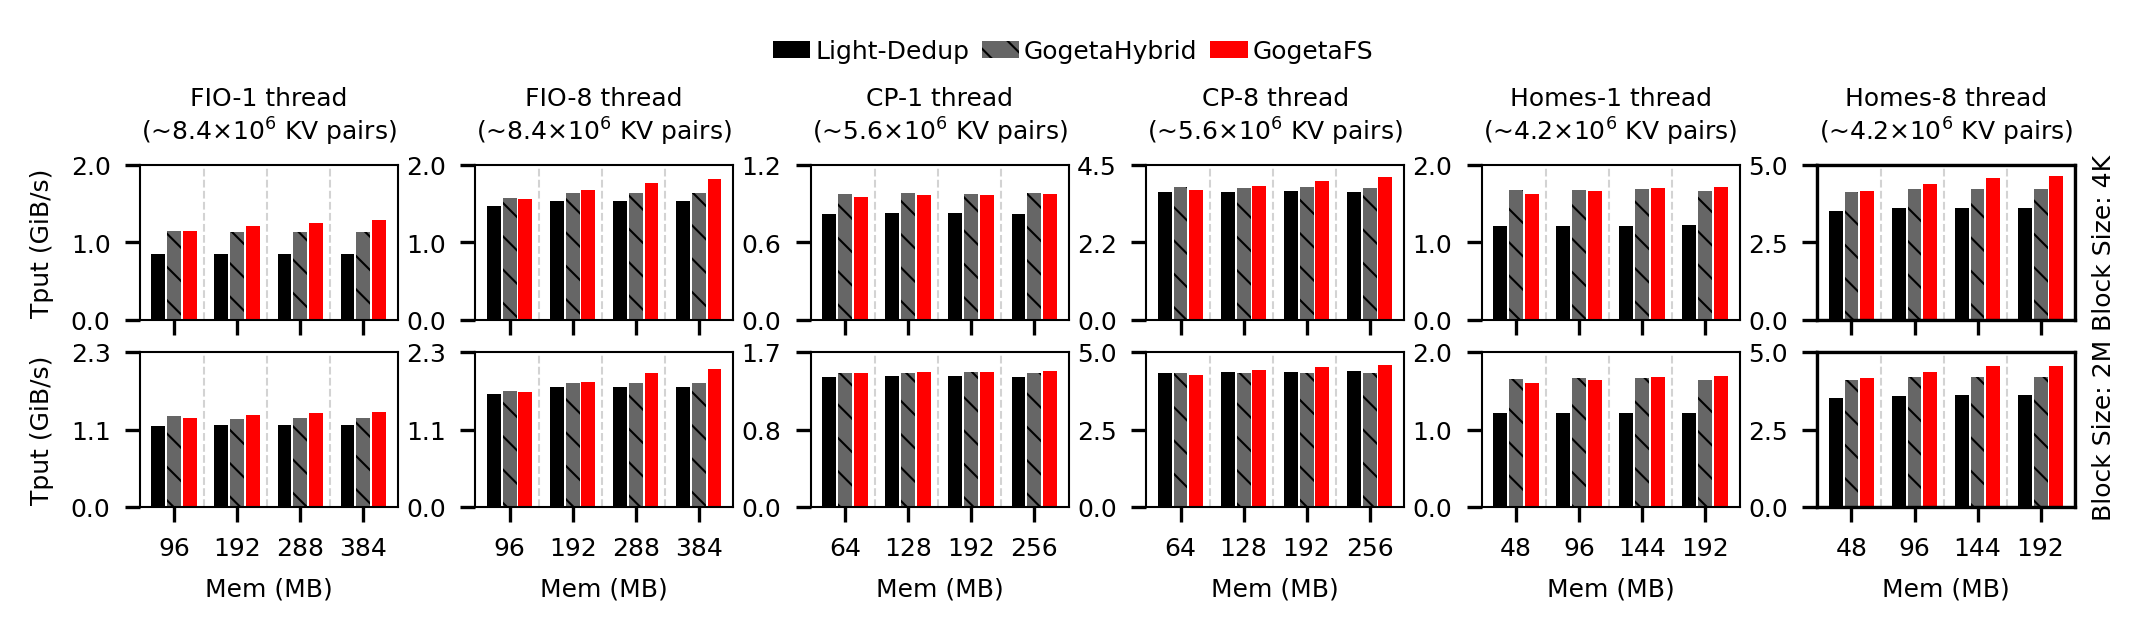

In [10]:
# ipython -c "%run plot.ipynb"

import matplotlib
from matplotlib import gridspec
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd
import numpy as np
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as mtick
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Paper specific settings
STANDARD_WIDTH = 17.8
SINGLE_COL_WIDTH = STANDARD_WIDTH / 2
DOUBLE_COL_WIDTH = STANDARD_WIDTH
def cm_to_inch(value):
    return value/2.54
    
# matplotlib style settings
# matplotlib style settings
plt.rcParams.update(plt.rcParamsDefault)
matplotlib.rcParams['text.usetex'] = False
%matplotlib inline
style.use('grayscale')
plt.rcParams["axes.grid"] = False
plt.rcParams["axes.grid.axis"] = "both"
plt.rcParams["grid.linestyle"] = ":"
plt.rcParams["grid.linewidth"] = 0.5
plt.rcParams["grid.color"] = "lightgray"
plt.rcParams['hatch.linewidth'] = 0.5
plt.rcParams["hatch.color"] = "black"
pd.options.display.max_columns = None
pd.options.display.max_rows = None

# Data Preprocessing
# with open("./avg-test-result-in-paper", "r") as f:
with open("./performance-comparison-table-cp-hybrid", "r") as f:
    df_cp_hybrid = pd.read_csv(f, delim_whitespace=True, index_col=None, engine='python')
with open("./performance-comparison-table-trace-hybrid", "r") as f:
    df_trace_hybrid = pd.read_csv(f, delim_whitespace=True, index_col=None, engine='python')
with open("./performance-comparison-table-4K-hybrid", "r") as f:
    df_fio_4K_hybrid = pd.read_csv(f, delim_whitespace=True, index_col=None, engine='python')
with open("./performance-comparison-table-continuous-hybrid", "r") as f:
    df_fio_continuous_hybrid = pd.read_csv(f, delim_whitespace=True, index_col=None, engine='python')
    
df = df_cp_hybrid
# df.drop(df[df['file_system'] == "PMM"].index, inplace=True)
# Plotting Settings
line_width = 0.5
# colors = ["#2b2d42", "#8d99ae", "#1a535c", "#ef233c", "#4ecdc4"]
marks = [">", "x", "o", "s", "D", "+", "v", "<", "d", "^", "p", "h", "H", "X", "*", "|", "_"]
# seven line types
line_types = ["-", "--", "-.", ":", "-", "--", "-.", ":", "-", "--", "-.", ":"]
# subtitles = ["(a) SW", "(b) RW", "(c) SR", "(d) RR", "(e) Strict-SW", "(f) Strict-RW"]
fss = ["Light-Dedup-J-PM-Table-P", "Light-Dedup-J-PM-Table", "Light-Dedup-J-Regulate"]

jobs = [1, 8]
blks = [1, 512]

reg_memses=[
    [96, 192, 288, 384],   # fio memory
    [96, 192, 288, 384],   # fio memory
    [64, 128, 192, 256],    # CP memory
    [64, 128, 192, 256],    # CP memory
    [48, 96, 144, 192],     # homes_fit memory
    [48, 96, 144, 192]     # homes_fit memory
]
reg_pts=[1, 2, 3, 4]

axes = []
lines = []
cmap = "tab10"

    
ylims = [
    [0, 2],
    [0, 2],
    [0, 1.2],
    [0, 4.5],
    [0, 2],
    [0, 5],
    
    [0, 2.3],
    [0, 2.3],
    [0, 1.7],
    [0, 5],
    [0, 2],
    [0, 5],
]

bar_width = 0.25
true_bar_width = 0.22
patterns = ['///', '\\\\\\', '', 'XXX', 'OOO', '---', '+++']

tot = len(fss) * bar_width

fig = plt.figure(dpi = 300, figsize = (cm_to_inch(DOUBLE_COL_WIDTH), cm_to_inch(4.5)))

fig.patch.set_facecolor('white')
df_seq = [df_fio_4K_hybrid, df_fio_4K_hybrid, df_cp_hybrid, df_cp_hybrid, df_trace_hybrid, df_trace_hybrid, df_fio_continuous_hybrid, df_fio_continuous_hybrid, df_cp_hybrid, df_cp_hybrid, df_trace_hybrid, df_trace_hybrid]

for blk_idx, blk in enumerate(blks):
    # subfig = plt.subplot(gs0[op_idx])
    for i in [0, 1, 2]:
        for job_idx, job in enumerate(jobs):
            fig_idx = blk_idx * 6 + i * 2 + job_idx
            subfig = plt.subplot(2, 6, fig_idx + 1)
            df = df_seq[fig_idx]
            for idx, fs in enumerate(fss):
                points = []
                for pivot in reg_pts:
                    point = pivot - tot / 2 + bar_width / 2 + idx * bar_width
                    points.append(point)
                bws = []
                reg_mems = reg_memses[fig_idx % 6]
                workload_name = ""
                for reg_mem in reg_mems:
                    if df is df_fio_4K_hybrid or df is df_fio_continuous_hybrid:
                        bws.append(df[(df['file_system'] == fs) & (df['swap_mem'] == reg_mem * 1024 * 1024) & (df['num_job'] == job)]["bandwidth(MiB/s)"].iloc[0] / 1024)
                        workload_name = "FIO"
                    elif df is df_cp_hybrid:
                        bws.append(df[(df['file_system'] == fs) & (df['swap_mem'] == reg_mem * 1024 * 1024) & (df['num_job'] == job) & (df['blks'] == blk)]["second_bw"].iloc[0] / 1024)
                        workload_name = "CP"
                    else:
                        bws.append(df[(df['file_system'] == fs) & (df['swap_mem'] == reg_mem * 1024 * 1024)  & (df['cblks'] == blk) & (df['job'] == job) & (df['trace'] == "homes_fit85.hitsztrace")]['bandwidth(MiB/s)'].iloc[0] / 1024)
                        workload_name = "Homes"
                if fs == "Light-Dedup-J-Regulate":
                    bar = plt.bar(points, bws, width=true_bar_width, hatch=patterns[idx], linewidth=0.5, color="red")
                    # draw the seperator for each group
                    for point in points[:-1]:
                        plt.axvline(x=point + true_bar_width, color='lightgray', linewidth=0.5, linestyle='--')
                else:
                    bar = plt.bar(points, bws, width=true_bar_width, hatch=patterns[idx], linewidth=0.5)
                    
                # bar, = plt.plot(reg_pts, bws, width=true_bar_width, hatch=patterns[idx], linewidth=0.5)
                    
                lines.append(bar)
                
                # if idx == 0:
                #     for bw_idx in range(len(bws)):
                #         plt.text(points[bw_idx], bws[bw_idx] + 0.05, "%.2f" % (bws[bw_idx]), ha='center', va='bottom', rotation=90, fontsize=5)
                
            ax = fig.gca()
            lw = 0.5
            for axis in ['top','bottom','left','right']:
                ax.spines[axis].set_linewidth(lw)
            if (blk_idx * 2 + job_idx + 1) > 2:
                plt.xlabel("Mem (MB)", fontsize=6)
                plt.xticks(reg_pts, labels=reg_mems, fontsize=6)
            else:
                plt.xticks(reg_pts, labels=[], fontsize=6)
                subfig.set_title(f"{workload_name}-{job} thread\n(~{round(reg_mems[3] * 1024 * 1024 / 48 / 1000000, 1)}×10$^6$ KV pairs)", fontsize=6)
            

            if (fig_idx + 1 in [1, 7]):
                plt.ylabel('Tput (GiB/s)', fontsize=6)
            
            ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))
            plt.ylim(ylims[fig_idx])
            yticks = np.linspace(ylims[fig_idx][0], ylims[fig_idx][1], 3)
            if (ylims[fig_idx][0] != 0):
                ax.get_yticklabels()[0].set_color("red")
            
            plt.yticks(yticks, fontsize=6)
            
            
            if (fig_idx + 1 in [6, 12]):
                ax2 = ax.twinx()
                ax2.set_ylabel("Block Size: 4K" if blk == 1 else "Block Size: 2M", fontsize=6)
                ax2.set_yticks([])
                ax2.set_yticklabels([])
            # axes.append(ax)

_fss = pd.Series(fss)
_fss.replace("Light-Dedup-J-Regulate", "GogetaFS", inplace=True)
_fss.replace("Light-Dedup-J-Log-Regulate", "GogetaLog", inplace=True)
_fss.replace("Light-Dedup-J-PM-Table", "GogetaHybrid", inplace=True)
_fss.replace("Light-Dedup-J-PM-Table-P", "Light-Dedup", inplace=True)
    
# "Light-Dedup-J-Regulate", "Light-Dedup-J-Log-Regulate", "Light-Dedup-J-PM-Table", "Light-Dedup-J-PM-Table-P"

# handles, labels = ax.get_legend_handles_labels()


fig.legend(lines, _fss, loc='center', bbox_to_anchor=(0.5, 1.05), ncol=7, fontsize=6, frameon=False, columnspacing=0.5, handletextpad=0.2, handlelength=1.5)

plt.tight_layout(pad=0.2)
# adjust_explanation(fig, axes, context, [1, 1, 1, 1, 0, 0])
# gs0.tight_layout(fig)

plt.savefig("./FIG-REAL-ALL-Hybrid.pdf", bbox_inches='tight', pad_inches=0)
